# Explainer Notebook - Project in 42578 Advanced Business Analytics
This notebook was formed as a part of the final project in Advanced Business Analytics course 42578 at DTU.

Team members:

- Daniel Ries (s214641)
- Karoline Klan Hansen (s214638)
- Kristoffer Helms Kjær (s214609)
- Felix Lund Frandsen (s214584)

Relevant Links:

Visit the [**Executive Summary**](#) for a high-level overview of the project, tailored to a non-technical business audience.
For full source code and project structure, visit the [**project GitHub repository**](https://github.com/KarolineKlan/advanced_ba_project). That is based on the [mlops cookie cutter template](https://github.com/SkafteNicki/mlops_template).

# Table of Contents
* [1. Introduction](#chapter1)
    * [1.1 Motivation and Objective](#section_1_1)
    * [1.2 Scope](#section_1_2)

* [2. The Data Foundation](#chapter2)
    * [2.1 Deep Globe](#section_2_1)
    * [2.2 Google Engine](#section_2_2)
   
* [3. The Convolutional Neural Network](#chapter3)
    * [3.1 U-Net Architecture](#section_3_1)

    * [3.2 Evaluation](#section_3_2)

* [4. Discussion and Conclusions](#chapter4)

* [5. References](#chapter5)

* [6. Contribution Statement](#chapter6)

***

# 1. Introduction <a class="anchor" id="chapter1"></a>

## 1.1 Motivation and Objective <a id="section_1_1"></a>

Deforestation is a significant driver of biodiversity loss and climate change. According to Our World in Data, deforestation has led to the loss of over 10 million hectares of forest annually in recent years, primarily driven by agriculture, logging, and infrastructure expansion [[1](#chapter5)]. Recognizing the urgency of this issue, the European Union has introduced the EU Deforestation Regulation (EUDR), which mandates stricter tracking and reporting of deforestation-linked resources [[2](#chapter5)]. 

This project aims to develop an AI-powered segmentation model to distinguish forests from non-forested areas in satellite images. This would lay the foundation for tracking land cover changes, which can later be integrated with a classification model to assess deforestation trends.

## 1.2 Scope <a id="section_1_2"></a>

The dataset used originates from the DeepGlobe 2018 Land Cover Classification Challenge [[3](#chapter5)], based on satellite imagery from Thailand, Indonesia, India, Bangladesh, and parts of the Middle East & North Africa. The dataset is a subset consisting of patches in a lower resolution than the original and does not include geolocation metadata. To make this model applicable for real-world deforestation monitoring future steps will be needed to integrate the satellite images from the Google Engine to track land cover changes over time. The idea behind the final model is that it should enable detection of deforestation in high-risk regions and help businesses in the wood industry comply with EUDR regulations.

**First Step:** Train a segmentation model to accurately detect forests from satellite images.



**Next Step:** Combine the segmentation model with time-series satellite imagery to analyze forest cover changes over time.


**Future Use Case:** Apply this model to real-world deforestation tracking to help businesses comply with EUDR regulations.


***


# 2. The Data Foundation <a class="anchor" id="chapter2"></a>

## 2.1 Deep Globe  <a id="section_2_1"></a>

Static data from kaggle.... introduce [[4](#chapter5)]




In [21]:
# Visualize the dataa and explain how it looks

## 2.2 Google Engine API  <a id="section_2_2"></a>

write stuff.... [[5](#chapter5)]

In [22]:
# choose what is relevant to show here

***

# 3. The Convolutional Neural Network <a class="anchor" id="chapter3"></a>

U-Net is a convolutional neural network architecture that is especially good for semantic segmentation tasks, where the goal is to assign a class label to each pixel in an image. 

The architecture follows a symmetric encoder–decoder structure:
- The encoder (contracting path) captures the context of the image using convolution and max-pooling layers.
- The decoder (expanding path) enables precise localization through upsampling and concatenation with high-resolution features from the encoder (via skip connections). (Image source: [[6](#chapter5)])
<figure>
    <img src="Unet_architecture.png" width="70%" alt="Unet">
    <figcaption style="text-align:left;font-style: italic;font-size:smaller;">Figure. 1: U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. </figcaption>
</figure>



Implemented model is found in the src folder of the project repository in the [model.py](https://github.com/KarolineKlan/advanced_ba_project/blob/main/src/advanced_ba_project/model.py) script. This setup was heavily inspired by a DTU 3-weeks course materials [[7](#chapter5)]. 

In [23]:
# Show the actual code here?

***

#### Karo playaround - should be removed:

In [19]:
import sys
from pathlib import Path

# Add the src folder to sys.path
sys.path.append(str(Path("../src").resolve()))
from advanced_ba_project.data import get_dataloaders  # Adjust 'project_name' to match your actual module name
# Define dataset path
data_path = Path("../data/raw/Forest Segmented")  # Adjust if necessary
metadata_file = "meta_data.csv"

# Load train and validation dataloaders
train_loader, val_loader = get_dataloaders(data_path, metadata_file, batch_size=16)

# Fetch a batch for visualization
images, masks = next(iter(train_loader))


Using Small Dataset - Train: 4341, Val: 767


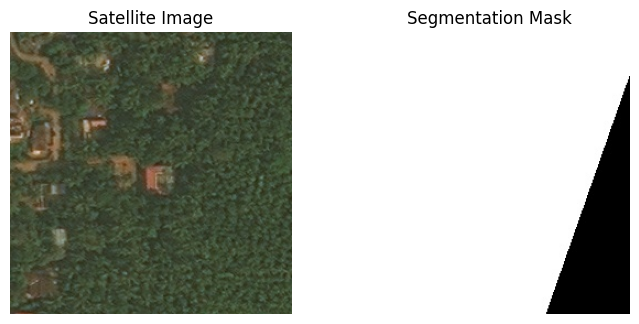

In [17]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy format for visualization
image_np = images[0].permute(1, 2, 0).numpy()  # Reshape (C, H, W) → (H, W, C)
mask_np = masks[0].squeeze(0).numpy()  # Remove the single color channel

# Plot image & mask
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((image_np * 0.5) + 0.5)  # Undo normalization for visualization
ax[0].set_title("Satellite Image")
ax[0].axis("off")

ax[1].imshow(mask_np, cmap="gray")
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()


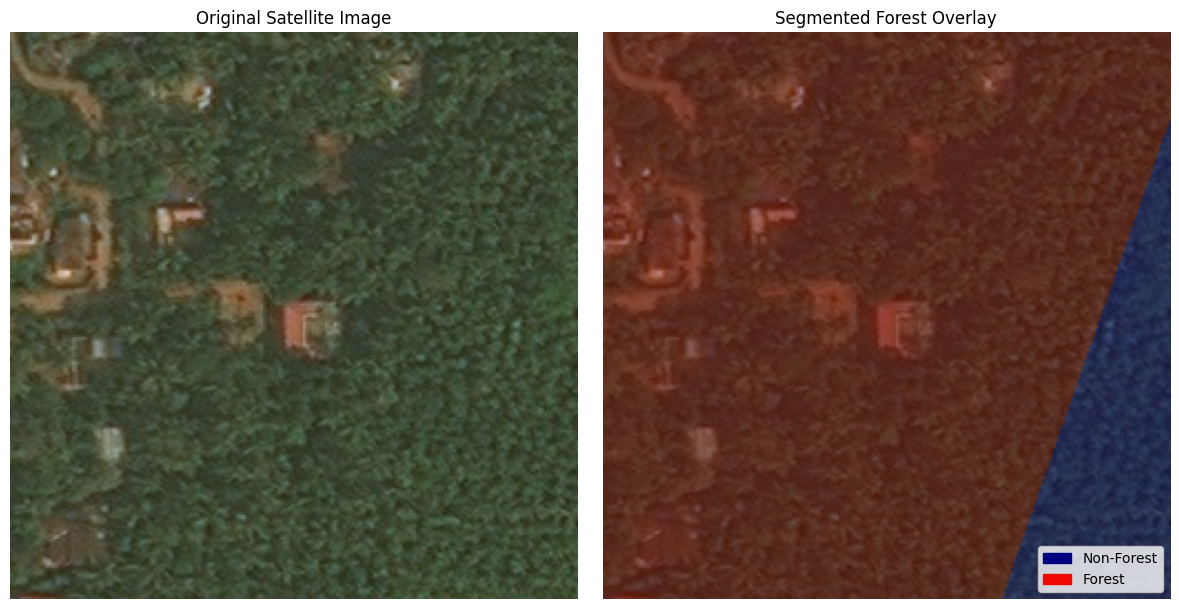

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch

# Function to overlay segmentation mask onto an image
def overlay_mask(image, mask, alpha=0.5, cmap="jet"):
    """
    Overlays a segmentation mask on top of an image.

    Args:
    - image (numpy array): Original image (H, W, C)
    - mask (numpy array): Grayscale mask (H, W), values should be 0-1
    - alpha (float): Transparency level of the mask overlay
    - cmap (str): Colormap to use for mask visualization

    Returns:
    - Merged image with mask overlay
    """
    color_mask = plt.get_cmap(cmap)(mask)[:, :, :3]  # Convert mask to color
    blended = (1 - alpha) * image + alpha * color_mask  # Blend with transparency
    return blended

# Select a sample
image_np = images[0].permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
image_np = (image_np * 0.5) + 0.5  # Undo normalization
mask_np = masks[0].squeeze(0).numpy()  # Convert (1, H, W) -> (H, W)

# Overlay mask on image
overlayed_image = overlay_mask(image_np, mask_np, alpha=0.4, cmap="jet")

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
ax[0].imshow(image_np)
ax[0].set_title("Original Satellite Image")
ax[0].axis("off")

# Overlayed Segmentation
ax[1].imshow(overlayed_image)
ax[1].set_title("Segmented Forest Overlay")
ax[1].axis("off")

# Add a color legend
cmap = plt.get_cmap("jet")
handles = [
    mpatches.Patch(color=cmap(0.0), label="Non-Forest"),
    mpatches.Patch(color=cmap(0.9), label="Forest"),
]
ax[1].legend(handles=handles, loc="lower right")

plt.tight_layout()
plt.show()


# 5. References <a class="anchor" id="chapter5"></a>

[1] Our World in Data, “Deforestation,” 2024. [Online]. Available: https://ourworldindata.org/deforestation. [Accessed: Mar. 26, 2025].


[2] European Commission, “Regulation on deforestation-free products,” 2024. [Online]. Available: https://environment.ec.europa.eu/topics/forests/deforestation/regulation-deforestation-free-products_en. [Accessed: Mar. 26, 2025].

[3] I. Demir, K. Koperski, D. Lindenbaum, G. Pang, J. Huang, S. Basu, F. Hughes, D. Tuia, and R. Raskar, “DeepGlobe 2018: A Challenge to Parse the Earth through Satellite Images,” in *2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW)*, Salt Lake City, UT, USA, Jun. 2018, pp. 172–17209. [Online]. Available: http://dx.doi.org/10.1109/CVPRW.2018.00031

[4] Q. Ahmed, “Augmented Forest Segmentation,” Kaggle, 2022. [Online]. Available: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation. [Accessed: Mar. 26, 2025].

[5] Google Developers, “Google Earth Engine,” 2024. [Online]. Available: https://developers.google.com/earth-engine. [Accessed: Mar. 26, 2025].

[6] O. Ronneberger, P. Fischer, and T. Brox, “U-Net: Convolutional Networks for Biomedical Image Segmentation,” in *Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015*, vol. 9351, Springer, 2015, pp. 234–241. [Online]. Available: https://arxiv.org/abs/1505.04597

[7] R. R. Paulsen, “DTU U-net course,” GitHub repository, 2023. [Online]. Available: https://github.com/RasmusRPaulsen/DTU-U-net-course. [Accessed: Mar. 26, 2025].



# 6. Contribution Statement <a class="anchor" id="chapter6"></a>